We will use graph classification to classify MNIST dataset 

In [11]:
import numpy as np
import tensorflow as tf
import networkx as nx
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import sparse_categorical_accuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

from spektral.data import MixedLoader
from spektral.datasets.mnist import MNIST
from spektral.layers import GCNConv
from spektral.utils.sparse import sp_matrix_to_sp_tensor



Parameters for training

In [2]:
batch_size = 32  # Batch size
epochs = 20  # Number of training epochs
patience = 10  # Patience for early stopping
l2_reg = 0.01  # Regularization rate for l2

Load data from MNIST from spektral

In [3]:
data = MNIST()

The graphs have the same adjacent matrix for all. A vertex is adjacent to other if they share the same border (1 step from queen move).

In [156]:
data.a[0]

<1x784 sparse matrix of type '<class 'numpy.float64'>'
	with 8 stored elements in Compressed Sparse Row format>

In [162]:
np.mean(data[0].x)

0.13768007202881152

In [6]:
data.a

<784x784 sparse matrix of type '<class 'numpy.float64'>'
	with 6396 stored elements in Compressed Sparse Row format>

In [7]:
sps_array = data.a.tocoo()

In [154]:
list(data.a)

[<1x784 sparse matrix of type '<class 'numpy.float64'>'
 	with 8 stored elements in Compressed Sparse Row format>,
 <1x784 sparse matrix of type '<class 'numpy.float64'>'
 	with 8 stored elements in Compressed Sparse Row format>,
 <1x784 sparse matrix of type '<class 'numpy.float64'>'
 	with 8 stored elements in Compressed Sparse Row format>,
 <1x784 sparse matrix of type '<class 'numpy.float64'>'
 	with 8 stored elements in Compressed Sparse Row format>,
 <1x784 sparse matrix of type '<class 'numpy.float64'>'
 	with 8 stored elements in Compressed Sparse Row format>,
 <1x784 sparse matrix of type '<class 'numpy.float64'>'
 	with 8 stored elements in Compressed Sparse Row format>,
 <1x784 sparse matrix of type '<class 'numpy.float64'>'
 	with 8 stored elements in Compressed Sparse Row format>,
 <1x784 sparse matrix of type '<class 'numpy.float64'>'
 	with 8 stored elements in Compressed Sparse Row format>,
 <1x784 sparse matrix of type '<class 'numpy.float64'>'
 	with 8 stored elements

In [155]:
e = np.transpose(np.nonzero(sps_array))
list(map(tuple,e))

[(0, 1),
 (0, 2),
 (0, 28),
 (0, 29),
 (0, 30),
 (0, 56),
 (0, 57),
 (0, 58),
 (1, 0),
 (1, 2),
 (1, 3),
 (1, 28),
 (1, 29),
 (1, 30),
 (1, 56),
 (1, 57),
 (2, 0),
 (2, 1),
 (2, 3),
 (2, 4),
 (2, 29),
 (2, 30),
 (2, 31),
 (2, 58),
 (3, 1),
 (3, 2),
 (3, 4),
 (3, 5),
 (3, 30),
 (3, 31),
 (3, 32),
 (3, 59),
 (4, 2),
 (4, 3),
 (4, 5),
 (4, 6),
 (4, 31),
 (4, 32),
 (4, 33),
 (4, 60),
 (5, 3),
 (5, 4),
 (5, 6),
 (5, 7),
 (5, 32),
 (5, 33),
 (5, 34),
 (5, 61),
 (6, 4),
 (6, 5),
 (6, 7),
 (6, 8),
 (6, 33),
 (6, 34),
 (6, 35),
 (6, 62),
 (7, 5),
 (7, 6),
 (7, 8),
 (7, 9),
 (7, 34),
 (7, 35),
 (7, 36),
 (7, 63),
 (8, 6),
 (8, 7),
 (8, 9),
 (8, 10),
 (8, 35),
 (8, 36),
 (8, 37),
 (8, 64),
 (9, 7),
 (9, 8),
 (9, 10),
 (9, 11),
 (9, 36),
 (9, 37),
 (9, 38),
 (9, 65),
 (10, 8),
 (10, 9),
 (10, 11),
 (10, 12),
 (10, 37),
 (10, 38),
 (10, 39),
 (10, 66),
 (11, 9),
 (11, 10),
 (11, 12),
 (11, 13),
 (11, 38),
 (11, 39),
 (11, 40),
 (11, 67),
 (12, 10),
 (12, 11),
 (12, 13),
 (12, 14),
 (12, 39),
 (12, 

In [ ]:
nd = data[0].x.reshape((784))
# (data[0].x.tolist())
# nd

In [26]:
G=nx.Graph()
# G = nx.grid_2d_graph(28,28)
G.add_nodes_from(list(range(784)))
G.add_edges_from(list(map(tuple,e)))
# for i in range(data[0].x.shape[0]):
#     G.add_node((data[0].x[i]))
# nx.draw(G)
# G

In [27]:
G.number_of_edges()

3198

In [28]:
G.number_of_nodes()

784

In [29]:
print(G)

Graph with 784 nodes and 3198 edges


In [104]:
# Create dictionary of position
fix_pos = {}
for i in range(784):
    fix_pos[i] = [i%28,i//28]

In [70]:
fix_pos

{0: [0, 0],
 1: [1, 0],
 2: [2, 0],
 3: [3, 0],
 4: [4, 0],
 5: [5, 0],
 6: [6, 0],
 7: [7, 0],
 8: [8, 0],
 9: [9, 0],
 10: [10, 0],
 11: [11, 0],
 12: [12, 0],
 13: [13, 0],
 14: [14, 0],
 15: [15, 0],
 16: [16, 0],
 17: [17, 0],
 18: [18, 0],
 19: [19, 0],
 20: [20, 0],
 21: [21, 0],
 22: [22, 0],
 23: [23, 0],
 24: [24, 0],
 25: [25, 0],
 26: [26, 0],
 27: [27, 0],
 28: [0, 1],
 29: [1, 1],
 30: [2, 1],
 31: [3, 1],
 32: [4, 1],
 33: [5, 1],
 34: [6, 1],
 35: [7, 1],
 36: [8, 1],
 37: [9, 1],
 38: [10, 1],
 39: [11, 1],
 40: [12, 1],
 41: [13, 1],
 42: [14, 1],
 43: [15, 1],
 44: [16, 1],
 45: [17, 1],
 46: [18, 1],
 47: [19, 1],
 48: [20, 1],
 49: [21, 1],
 50: [22, 1],
 51: [23, 1],
 52: [24, 1],
 53: [25, 1],
 54: [26, 1],
 55: [27, 1],
 56: [0, 2],
 57: [1, 2],
 58: [2, 2],
 59: [3, 2],
 60: [4, 2],
 61: [5, 2],
 62: [6, 2],
 63: [7, 2],
 64: [8, 2],
 65: [9, 2],
 66: [10, 2],
 67: [11, 2],
 68: [12, 2],
 69: [13, 2],
 70: [14, 2],
 71: [15, 2],
 72: [16, 2],
 73: [17, 2],
 74:

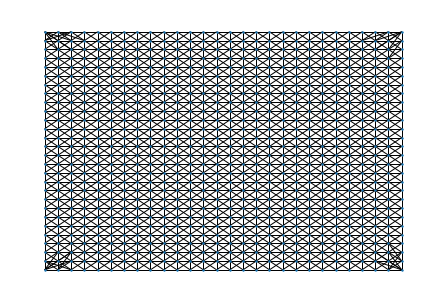

In [45]:
p=nx.random_layout(G)
nx.draw(G, pos=fix_pos,node_size=2)

In [ ]:
dat_str = data[0]

In [6]:
# The adjacency matrix is stored as an attribute of the dataset.
# Create filter for GCN and convert to sparse tensor.
data.a = GCNConv.preprocess(data.a)
data.a = sp_matrix_to_sp_tensor(data.a)

In [7]:
data.a

In [143]:
dat_str = data[2]
test = dat_str.x
test = test.reshape((28,28))

In [144]:
color_map = []
for i in range(28):
    for j in range(28):
        if test[27-i,j] > 0.3:
            color_map.append('red')
        else:
            color_map.append('white')


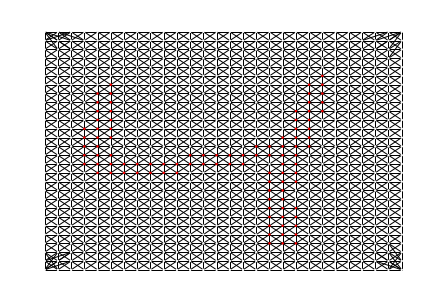

In [145]:
nx.draw(G, pos=fix_pos,node_size=2, node_color = color_map)

In [146]:
dat_str.y

4

In [158]:
dat_str.x.shape

(784, 1)

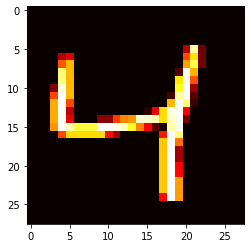

In [147]:
import matplotlib.pyplot as plt
plt.imshow(test, cmap = 'hot')

Creating a graph by Spektral

In [ ]:
from spektral.data import Graph
g = Graph(x = np.array([0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0]), y = 9)
# g.x = np.array([0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0])

In [ ]:
g.x

In [ ]:
g.y

In [ ]:
# Train/valid/test split
data_tr, data_te = data[:-10000], data[-10000:]
np.random.shuffle(data_tr)
data_tr, data_va = data_tr[:-10000], data_tr[-10000:]

# We use a MixedLoader since the dataset is in mixed mode
loader_tr = MixedLoader(data_tr, batch_size=batch_size, epochs=epochs)
loader_va = MixedLoader(data_va, batch_size=batch_size)
loader_te = MixedLoader(data_te, batch_size=batch_size)

In [ ]:
# Build model
class Net(Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.conv1 = GCNConv(64, activation="elu", kernel_regularizer=l2(l2_reg), use_bias=True)
        self.conv2 = GCNConv(32, activation="elu", kernel_regularizer=l2(l2_reg), use_bias=True)
        self.conv3 = GCNConv(16, activation="elu", kernel_regularizer=l2(l2_reg), use_bias=True)
        self.flatten = Flatten()
        self.fc1 = Dense(512, activation="relu")
        self.fc2 = Dense(10, activation="softmax")  # MNIST has 10 classes

    def call(self, inputs):
        x, a = inputs
        x = self.conv1([x, a])
        x = self.conv2([x, a])
        x = self.conv3([x, a])
        output = self.flatten(x)
        output = self.fc1(output)
        output = self.fc2(output)

        return output

In [ ]:
# Create model
model = Net()
optimizer = Adam()
loss_fn = SparseCategoricalCrossentropy()

In [ ]:
# Training function
@tf.function
def train_on_batch(inputs, target):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        loss = loss_fn(target, predictions)  + sum(model.losses)
        acc = tf.reduce_mean(sparse_categorical_accuracy(target, predictions))

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss, acc

In [ ]:
# Evaluation function
def evaluate(loader):
    step = 0
    results = []
    for batch in loader:
        step += 1
        inputs, target = batch
        predictions = model(inputs, training=False)
        loss = loss_fn(target, predictions)
        acc = tf.reduce_mean(sparse_categorical_accuracy(target, predictions))
        results.append((loss, acc, len(target)))  # Keep track of batch size
        if step == loader.steps_per_epoch:
            results = np.array(results)
            return np.average(results[:, :-1], 0, weights=results[:, -1])

In [ ]:
# Setup training
best_val_loss = 99999
current_patience = patience
step = 0

In [ ]:
# Training loop
results_tr = []
for batch in loader_tr:
    step += 1

    # Training step
    inputs, target = batch
    loss, acc = train_on_batch(inputs, target)
    results_tr.append((loss, acc, len(target)))

    if step == loader_tr.steps_per_epoch:
        results_va = evaluate(loader_va)
        if results_va[0] < best_val_loss:
            best_val_loss = results_va[0]
            current_patience = patience
            results_te = evaluate(loader_te)
        else:
            current_patience -= 1
            if current_patience == 0:
                print("Early stopping")
                break

        # Print results
        results_tr = np.array(results_tr)
        results_tr = np.average(results_tr[:, :-1], 0, weights=results_tr[:, -1])
        print(
            "Train loss: {:.4f}, acc: {:.4f} | "
            "Valid loss: {:.4f}, acc: {:.4f} | "
            "Test loss: {:.4f}, acc: {:.4f}".format(
                *results_tr, *results_va, *results_te
            )
        )

        # Reset epoch
        results_tr = []
        step = 0